In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import validate
from sklearn.decomposition import PCA
import math
import sys

In [2]:
class FeatureExtractor():
    ''' 特徴量(FBANK, MFCC)を抽出するクラス
    sample_frequency: 入力波形のサンプリング周波数 [Hz]
    frame_length: フレームサイズ [秒]
    frame_shift: 分析間隔(フレームシフト) [秒]
    num_mel_bins: メルフィルタバンクの数(=FBANK特徴の次元数)
    num_ceps: MFCC特徴の次元数(0次元目を含む)
    lifter_coef: リフタリング処理のパラメータ
    low_frequency: 低周波数帯域除去のカットオフ周波数 [Hz]
    high_frequency: 高周波数帯域除去のカットオフ周波数 [Hz]
    dither: ディザリング処理のパラメータ(雑音の強さ)
    '''
    # クラスを呼び出した時点で最初に1回実行される関数
    def __init__(self, 
                 sample_frequency=5, 
                 fft_size=2**6,
                 num_mel_bins=5, 
                 low_frequency=0, 
                 high_frequency=2.5):
        # サンプリング周波数[Hz]
        self.sample_freq = sample_frequency
        # メルフィルタバンクの数
        self.num_mel_bins = num_mel_bins
        # 低周波数帯域除去のカットオフ周波数[Hz]
        self.low_frequency = low_frequency
        # 高周波数帯域除去のカットオフ周波数[Hz]
        self.high_frequency = high_frequency
        # FFTのポイント数 
        self.fft_size = fft_size
        # メルフィルタバンクを作成する
        self.mel_filter_bank = self.MakeMelFilterBank()


    def Herz2Mel(self, herz):
        ''' 周波数をヘルツからメルに変換する
        '''
        return (1127.0 * np.log(1.0 + herz / 700))


    def MakeMelFilterBank(self):
        ''' メルフィルタバンクを作成する
        '''
        # メル軸での最大周波数
        mel_high_freq = self.Herz2Mel(self.high_frequency)
        # メル軸での最小周波数
        mel_low_freq = self.Herz2Mel(self.low_frequency)
        # 最小から最大周波数まで，
        # メル軸上での等間隔な周波数を得る
        mel_points = np.linspace(mel_low_freq, 
                                 mel_high_freq, 
                                 self.num_mel_bins+2)

        # パワースペクトルの次元数 = FFTサイズ/2+1
        # ※Kaldiの実装ではナイキスト周波数成分(最後の+1)は
        # 捨てているが，本実装では捨てずに用いている
        dim_spectrum = int(self.fft_size / 2) + 1

        # メルフィルタバンク(フィルタの数 x スペクトルの次元数)
        mel_filter_bank = np.zeros((self.num_mel_bins, dim_spectrum))
        for m in range(self.num_mel_bins):
            # 三角フィルタの左端，中央，右端のメル周波数
            left_mel = mel_points[m]
            center_mel = mel_points[m+1]
            right_mel = mel_points[m+2]
            # パワースペクトルの各ビンに対応する重みを計算する
            for n in range(dim_spectrum):
                # 各ビンに対応するヘルツ軸周波数を計算
                freq = 1.0 * n * self.sample_freq/2 / dim_spectrum
                # メル周波数に変換
                mel = self.Herz2Mel(freq)
                # そのビンが三角フィルタの範囲に入っていれば，重みを計算
                if mel > left_mel and mel < right_mel:
                    if mel <= center_mel:
                        weight = (mel - left_mel) / (center_mel - left_mel)
                    else:
                        weight = (right_mel-mel) / (right_mel-center_mel)
                    mel_filter_bank[m][n] = weight
         
        return mel_filter_bank
    
    
    def ExtractWindow(self, window, num_samples):
        '''
        1フレーム分の波形データを抽出し，前処理を実施する．
        また，対数パワーの値も計算する
        '''
        # hamming窓をかける 
        window *= np.hamming(self.fft_size)

        return window


    def ComputeFBANK(self, waveform):
        '''メルフィルタバンク特徴(FBANK)を計算する
        出力1: fbank_features: メルフィルタバンク特徴
        出力2: log_power: 対数パワー値(MFCC抽出時に使用)
        '''
        # 波形データの総サンプル数
        num_samples = np.size(waveform)
        # メルフィルタバンク特徴
        fbank_features = np.zeros(self.num_mel_bins)
        
        window= self.ExtractWindow(waveform, num_samples)

        # 高速フーリエ変換(FFT)を実行
        spectrum = np.fft.fft(window, n=self.fft_size)
        # FFT結果の右半分(負の周波数成分)を取り除く
        # ※Kaldiの実装ではナイキスト周波数成分(最後の+1)は捨てているが，
        # 本実装では捨てずに用いている
        spectrum = spectrum[:int(self.fft_size/2) + 1]

        # パワースペクトルを計算する
        spectrum = np.abs(spectrum) ** 2

        # メルフィルタバンクを畳み込む
        fbank = np.dot(spectrum, self.mel_filter_bank.T)

        # 対数計算時に-infが出力されないよう，フロアリング処理を行う
        fbank[fbank<0.1] = 0.1

        # 対数をとってfbank_featuresに加える
        fbank_features= np.log(fbank)

        return fbank_features

In [3]:
df = pd.read_csv( os.path.join('csv_label', 'learning_data_10.csv') )
df=df.loc[df['day']<=2]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
1151450,53.6,0,6,2
1151451,53.8,0,6,2
1151452,53.1,0,6,2
1151453,53.0,0,6,2


In [4]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

df_list=[]
for i in set(df['day']):
    lag=[] 
    window_len= 2**6
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window_len))
    lag.append(df.loc[df['day']==i, ['day']])
    lag.append(make_label(df.loc[df['day']==i, ['label']], window_len))
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,original_lag6,original_lag7,original_lag8,original_lag9,...,original_lag56,original_lag57,original_lag58,original_lag59,original_lag60,original_lag61,original_lag62,original_lag63,day,label
0,53.2,54.2,54.6,55.1,55.5,55.5,55.9,57.2,57.1,57.3,...,55.7,54.7,54.0,53.6,53.2,52.8,52.8,53.4,0,0
1,52.6,53.2,54.2,54.6,55.1,55.5,55.5,55.9,57.2,57.1,...,55.5,55.7,54.7,54.0,53.6,53.2,52.8,52.8,0,0
2,52.0,52.6,53.2,54.2,54.6,55.1,55.5,55.5,55.9,57.2,...,55.7,55.5,55.7,54.7,54.0,53.6,53.2,52.8,0,0
3,52.1,52.0,52.6,53.2,54.2,54.6,55.1,55.5,55.5,55.9,...,55.6,55.7,55.5,55.7,54.7,54.0,53.6,53.2,0,0
4,52.4,52.1,52.0,52.6,53.2,54.2,54.6,55.1,55.5,55.5,...,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151261,53.6,54.3,55.1,55.2,55.6,56.2,56.4,56.8,56.4,56.0,...,47.6,48.3,49.0,47.9,46.9,47.2,47.3,47.0,2,0
1151262,53.8,53.6,54.3,55.1,55.2,55.6,56.2,56.4,56.8,56.4,...,47.4,47.6,48.3,49.0,47.9,46.9,47.2,47.3,2,0
1151263,53.1,53.8,53.6,54.3,55.1,55.2,55.6,56.2,56.4,56.8,...,47.7,47.4,47.6,48.3,49.0,47.9,46.9,47.2,2,0
1151264,53.0,53.1,53.8,53.6,54.3,55.1,55.2,55.6,56.2,56.4,...,47.9,47.7,47.4,47.6,48.3,49.0,47.9,46.9,2,0


In [5]:
num_df=len(df)
num_mel_bins=4
feat_extractor = FeatureExtractor(
                       sample_frequency=5, 
                       low_frequency=0, 
                       high_frequency=2.5,
                        fft_size=window_len, 
                        num_mel_bins=num_mel_bins)
fbank= np.zeros((num_df, num_mel_bins))
for i in range(num_df):
    fbank[i]=feat_extractor.ComputeFBANK(df.loc[i, df.columns[:-2]].values)

In [6]:
data=pd.DataFrame(fbank)
df=pd.concat([data, df['day'], df['label'], df['original']], axis=1)
df

,0,1,2,3,day,label,original
0,11.478947,2.034715,1.592008,1.242860,0,0,53.2
1,11.480529,2.049639,1.597869,1.274693,0,0,52.6
2,11.483073,2.093699,1.601215,1.325481,0,0,52.0
3,11.486542,2.146352,1.626109,1.364263,0,0,52.1
4,11.490925,2.188337,1.642598,1.415841,0,0,52.4
...,...,...,...,...,...,...,...
1151261,11.498958,4.702585,4.093832,3.899792,2,0,53.6
1151262,11.511276,4.678846,4.053640,3.870414,2,0,53.8
1151263,11.523217,4.646943,4.013333,3.810706,2,0,53.1
1151264,11.534557,4.599736,3.966018,3.770321,2,0,53.0


In [7]:
test_day=[1]
train=df[(df['label']==0)&(~df['day'].isin(test_day))][df.columns[:-3]].values
test=df[(df['day'].isin(test_day))][df.columns[:-3]].values

In [24]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=500,
                           novelty=True)
model.fit(train) # train_dataは正常データが大多数であるような訓練データ
prediction = model.predict(test) # テストデータに対する予測
score = model.score_samples(test) # テストデータの異常度

In [25]:
test_for_plot=df.loc[df['day'].isin(test_day), 'original'].values
test_for_plot

array([44.4, 44.1, 44.3, ..., 45.9, 45.9, 46.1])

In [26]:
data_unit=17999
num_ax=math.floor(len(test_for_plot)/data_unit)
label=df[(df['day'].isin(test_day))]['label'].values*100
label_index=range(len(label))
abnorm=(score*-2)**2
time=[t*0.2/60 for t in range(len(abnorm))]

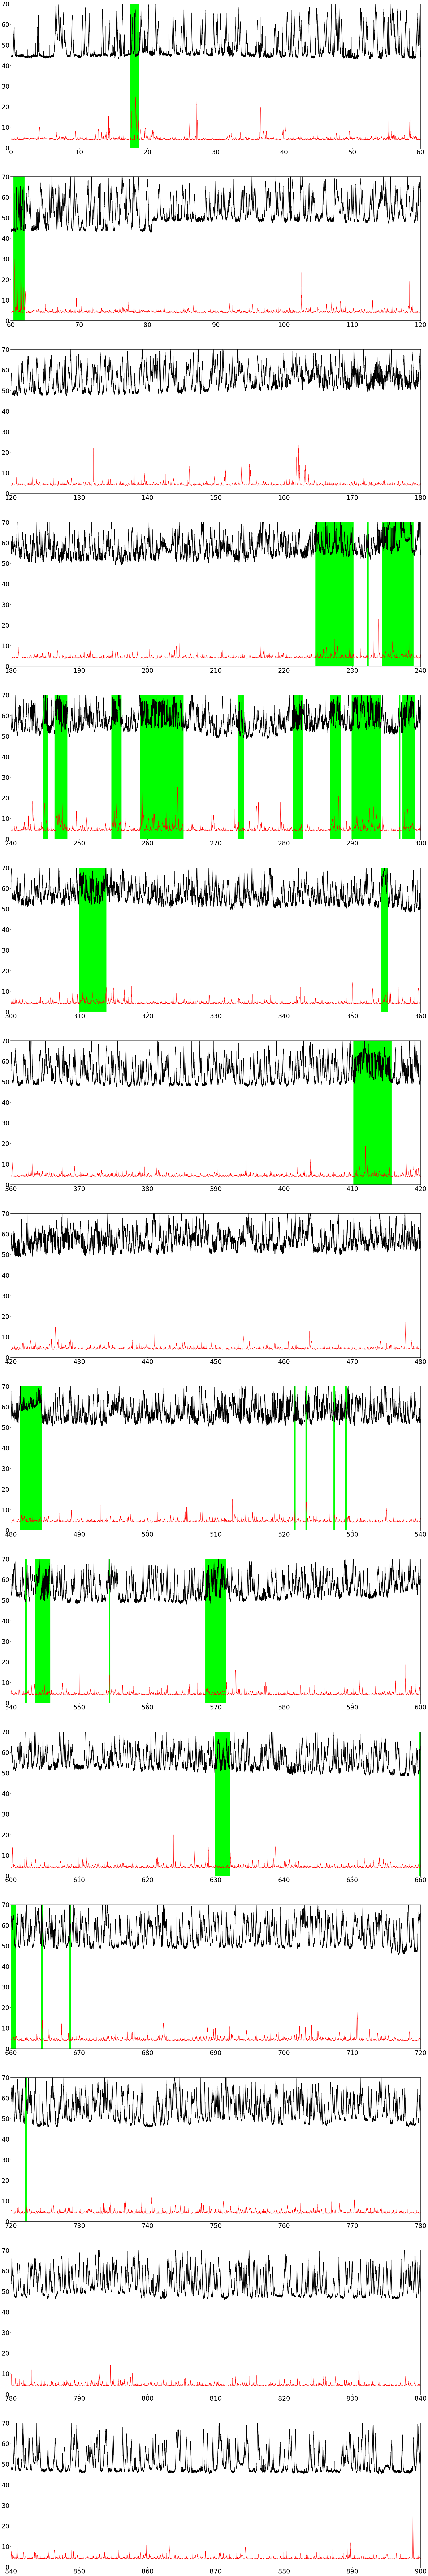

In [27]:
fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
time_unit=60
plt.rcParams["font.size"] = 30
for i in range(num_ax):
    ax[i].plot(time, abnorm, '-r',linewidth = 1 )
    ax[i].plot(time, test_for_plot, '-k',linewidth = 2)
    ax[i].fill_between(time, label, facecolor='lime' )
    ax[i].set_ylim(0, 70)
    ax[i].set_xlim(i*(time_unit), (time_unit)*(i+1))
plt.show()